In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

In [4]:
n_process = 8

# load data

In [5]:
save_dir = 'result_kernel'
data_dir = 'data'

In [6]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)

In [7]:
data_network

,row,col
0,1,2311
1,1,3144
2,1,3568
3,1,3603
4,2,2146
...,...,...
9917,3999,3227
9918,4000,279
9919,4000,2085
9920,4000,3306


In [8]:
n_node = len(data_latent); n_node

4000

In [9]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [10]:
Zs = data_latent.values
G = KECENI.Graph(Adj, Zs=Zs)

# hyperparameters

In [11]:
from hyperparams import delta, delta_mu, delta_pi

# counterfactual of interest

In [12]:
i0s = np.arange(0,n_node,10)

In [13]:
T0s_0 = np.full(n_node, 0)
T0s_1 = np.full(n_node, 1)

In [14]:
T0s = np.stack([T0s_0, T0s_1], 0)

# groundtruth

In [15]:
EYTR_1, EYTR_0 = (0.593984501067794, 0.40608837990296737)
EYTR_d = EYTR_1 - EYTR_0

In [16]:
EYTR_0, EYTR_1, EYTR_d

(0.40608837990296737, 0.593984501067794, 0.18789612116482662)

# estimation

In [17]:
n_sim = 40

## - load simulation

In [18]:
lamdas = np.linspace(0, 20, 21)[1:]

In [19]:
YGs_0 = np.zeros((n_sim,)+i0s.shape); YGs_1 = np.zeros((n_sim,)+i0s.shape); YGs_d = np.zeros((n_sim,)+i0s.shape)
YDRs_0 = np.zeros((n_sim,)+i0s.shape); YDRs_1 = np.zeros((n_sim,)+i0s.shape); YDRs_d = np.zeros((n_sim,)+i0s.shape)

In [20]:
for i_sim in np.arange(n_sim):
    locals().update(np.load('%s/result_%.3d.npz'%(save_dir,i_sim)))
    YGs_0[i_sim] = YG_0; YGs_1[i_sim] = YG_1; YGs_d[i_sim] = YG_d
    YDRs_0[i_sim] = YDR_0[id_cv]; YDRs_1[i_sim] = YDR_1[id_cv]; YDRs_d[i_sim] = YDR_d[id_cv]

In [21]:
EYGs_0, EYGs_1, EYGs_d = (YGs_0.mean(-1), YGs_1.mean(-1), YGs_d.mean(-1))
EYDRs_0, EYDRs_1, EYDRs_d = (YDRs_0.mean(-1), YDRs_1.mean(-1), YDRs_d.mean(-1))

## - G estimate

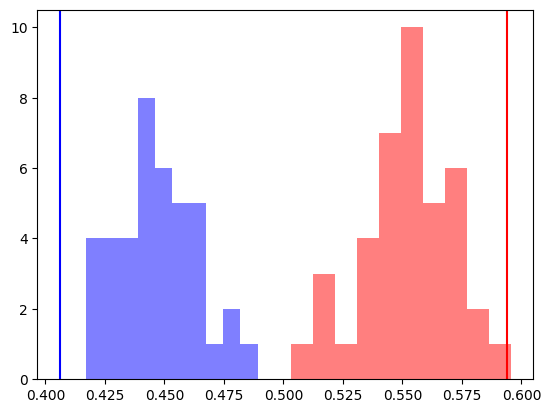

In [22]:
plt.hist(EYGs_1, color='red', alpha=0.5)
plt.axvline(EYTR_1, color='red')
plt.hist(EYGs_0, color='blue', alpha=0.5)
plt.axvline(EYTR_0, color='blue')

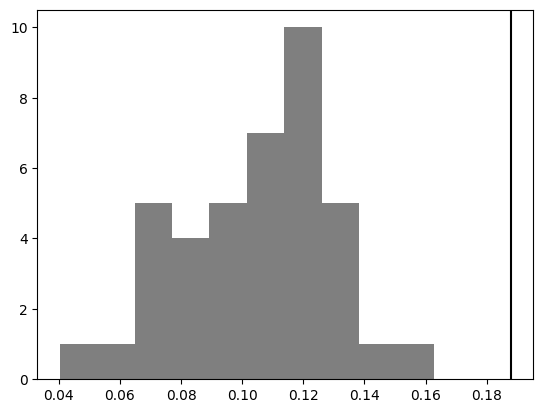

In [23]:
plt.hist(EYGs_d, color='black', alpha=0.5)
plt.axvline(EYTR_d, color='black')

In [24]:
np.sqrt(np.mean((EYGs_d - EYTR_d)**2, 0))

0.08701816928148506

## -DR estimate

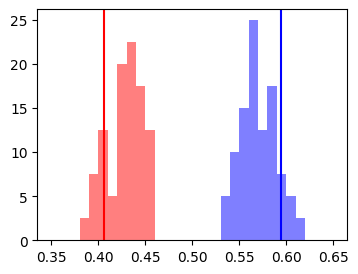

In [25]:
fig = plt.figure(figsize=(4,3))
plt.hist(EYDRs_1, color='blue', alpha=0.5, density=True, bins=np.arange(0.35,0.65,0.01))
plt.axvline(EYTR_1, color='blue')
plt.hist(EYDRs_0, color='red', alpha=0.5, density=True, bins=np.arange(0.35,0.65,0.01))
plt.axvline(EYTR_0, color='red')

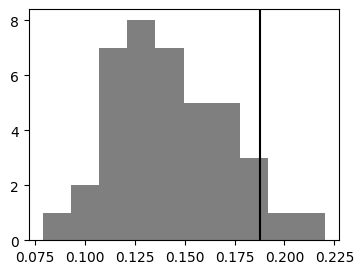

In [26]:
fig = plt.figure(figsize=(4,3))
plt.hist(EYDRs_d, color='black', alpha=0.5)
plt.axvline(EYTR_d, color='black')

In [27]:
np.sqrt(np.mean((EYDRs_d - EYTR_d)**2, 0))

0.05345653852450399